# Clasification with preprocessing

## Objective
The objective of this part is to describe the image preprocessing process, including the application of at least 5 filters and transformations, to improve the classification of dogs and cats. The aim is to highlight the contribution of each component to the system as a whole and ensure a clear and reproducible presentation.

### Project Steps

#### 1. Hypothesis Generation: 
Initially, we generate hypotheses about what types of filters could improve the quality of the images or be beneficial for our project. These hypotheses are based on prior knowledge and intuition about image processing.

#### 2. Initial Tests: 
We apply the selected filters in a certain order to our test images. These initial tests give us an idea of how filters may affect images and whether our initial hypotheses are effective.

#### 3. Results Evaluation: 
We evaluate the results of the initial tests using specific metrics and criteria. This allows us to objectively measure how the filters affect the quality of the images and whether they improve or worsen the visual information relevant to our project.

#### 4. Iteration and Adjustment: 
Based on the test results, we adjust our hypotheses and proceed to iterate in the process. This may include modifying the selected filters, changing their order of application, or testing different combinations to determine which are most effective.

#### 5. Continuous Analysis: 
We continue a cycle of trial and error, adjusting our strategies and trying new filter combinations until we achieve the desired results or a substantial improvement in image quality for our project.

## Code solution:


In [68]:
import cv2
import os
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from tqdm import tqdm
from rembg import remove


### Definition of directories:

In [39]:
input_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgo2'
output_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgo3'
train_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V3'
train2_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V4'
train_dir = r"C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V3\\train"
val_dir = r"C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V3\\val"

### Image processing without filters

In [40]:
os.makedirs(train_directory, exist_ok=True)
image_files = os.listdir(input_directory)
random.shuffle(image_files)

# Define the ratio for splitting the dataset
train_ratio = 0.6
val_ratio = 0.4

# Split the image files into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=val_ratio, random_state=42)


train_dir = os.path.join(train_directory, 'train')
val_dir = os.path.join(train_directory, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for file in train_files:
    src_path = os.path.join(input_directory, file)
    dst_path = os.path.join(train_dir, file)
    shutil.copy2(src_path, dst_path)  
    
for file in val_files:
    src_path = os.path.join(input_directory, file)
    dst_path = os.path.join(val_dir, file)
    shutil.copy2(src_path, dst_path)  

print(f"Total images: {len(image_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

Total images: 103
Training images: 61
Validation images: 42


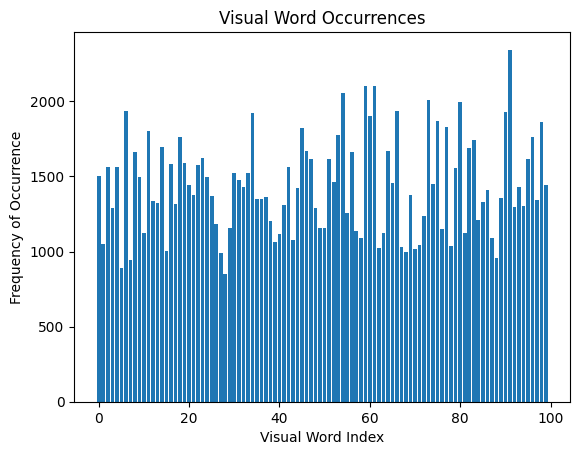

Done


In [41]:

# Parameters for SIFT and BoVW
sift = cv2.SIFT_create()
K = 100  

# Load the training images and extract SIFT descriptors
all_descriptors = []
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(train_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            all_descriptors.extend(des)

# Check if descriptors contain NaN or infinite values 
if np.any(np.isnan(all_descriptors)) or np.any(np.isinf(all_descriptors)):
    raise ValueError("Descriptors contain NaN or infinite values.")

# Check if K is greater than 0
if K <= 0:
    raise ValueError("The number of clusters K must be greater than 0.")

# Perform k-means clustering to create the visual vocabulary
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(np.float32(all_descriptors), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
vocabulary = centers

# Plot a histogram of visual word occurrences
histogram = np.bincount(labels.flatten(), minlength=K)
plt.bar(range(K), histogram)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency of Occurrence")
plt.title("Visual Word Occurrences")
plt.show()

# Save the vocabulary for later use if needed
np.save('visual_vocabulary.npy', vocabulary)

print("Done")

In [42]:
# Load the visual vocabulary 
vocabulary = np.load('visual_vocabulary.npy')

# Function to compute visual word histograms for a set of images
def compute_histograms(images, vocabulary, sift):
    histograms = []
    K = len(vocabulary)

    for image_path in images:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            # Initialize a histogram with zeros
            histogram = np.zeros(K, dtype=int)

            # Assign each descriptor to the nearest visual word in the vocabulary
            for descriptor in des:
                distances = np.linalg.norm(descriptor - vocabulary, axis=1)
                nearest_visual_word_index = np.argmin(distances)
                histogram[nearest_visual_word_index] += 1

            histograms.append(histogram)

    return np.array(histograms)

# Load the training and validation images
train_images = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir) if filename.endswith('.jpg')]
val_images = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir) if filename.endswith('.jpg')]

# Create histograms for training images
train_histograms = compute_histograms(train_images, vocabulary, sift)

# Labels for training data (e.g., 1 for cats, 0 for dogs)
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])

# Create an SVM classifier and train it
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the training set
train_predictions = svm_classifier.predict(train_histograms)

# Calculate accuracy for the training set
training_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Create a confusion matrix for the training set
confusion_mat = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix (Training Set):")
print(confusion_mat)

Training Accuracy: 100.00%
Confusion Matrix (Training Set):
[[35  0]
 [ 0 26]]


In [43]:
# Train an SVM classifier
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the validation set
val_histograms = compute_histograms(val_images, vocabulary, sift)
val_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(val_dir) if filename.endswith('.jpg')])
val_predictions = svm_classifier.predict(val_histograms)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy \n without filter  {accuracy * 100:.2f}%")

# Create a confusion matrix for the validation set
confusion_mat = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix: ")
print(confusion_mat)

Validation Accuracy: 73.81%
Confusion Matrix: 
[[12  4]
 [ 7 19]]


### Image processing with filters

In [251]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

image_files = os.listdir(input_directory)


def realzar_color(imagen, factor_realce):
    # Convierte la imagen a LAB
    imagen_lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

    # Escala el canal 'a' en el espacio LAB para realzar el color
    imagen_lab[:,:,1] = np.clip(imagen_lab[:,:,1] * factor_realce, 0, 255).astype(np.uint8)

    # Convierte la imagen de vuelta a BGR
    imagen_realzada = cv2.cvtColor(imagen_lab, cv2.COLOR_LAB2BGR)

    return imagen_realzada

def enhance_and_resize_image(image):
    if image is not None:
        
        # Apply Erosion Filter 2 (we count enhance)
        kernel = np.ones((5, 5), np.uint8)

       
        image1 = cv2.erode(image, kernel, iterations=1)
        
        # Convert to grayscale Filter 3
        image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        
 
        # Apply Sharpening Filter Filter 4
        sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
        image5 = cv2.filter2D(image2, -1, sharpening_kernel)

        # Apply remove FIlter 5
        
        image6 = remove(image5)
        
        return image6
    else:
        return None

 
image_count = 0


for image_file in tqdm(image_files, desc="Processing images"):
    #imagen original
    image_path = os.path.join(input_directory, image_file)
    image = cv2.imread(image_path)

    enhanced_image = enhance_and_resize_image(image)
    

    if enhanced_image is not None:
      
        output_path = os.path.join(output_directory, image_file)
        cv2.imwrite(output_path, enhanced_image)

        image_count += 1

           

Processing images: 100%|██████████| 194/194 [09:12<00:00,  2.85s/it]


In [252]:
os.makedirs(train2_directory, exist_ok=True)
image_files = os.listdir(output_directory)
random.shuffle(image_files)

# Define the ratio for splitting the dataset
train_ratio = 0.6
val_ratio = 0.4

# Split the image files into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=val_ratio, random_state=42)


train_dir = os.path.join(train2_directory, 'train')
val_dir = os.path.join(train2_directory, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for file in train_files:
    src_path = os.path.join(output_directory, file)
    dst_path = os.path.join(train_dir, file)
    shutil.copy2(src_path, dst_path)  
    
for file in val_files:
    src_path = os.path.join(output_directory, file)
    dst_path = os.path.join(val_dir, file)
    shutil.copy2(src_path, dst_path)  

print(f"Total images: {len(image_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

Total images: 194
Training images: 116
Validation images: 78


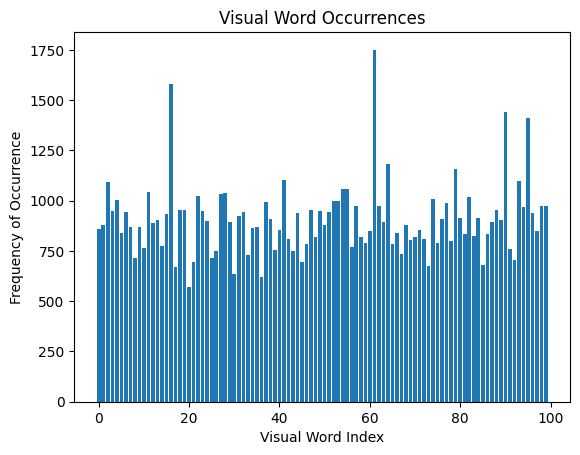

Done


In [253]:

# Parameters for SIFT and BoVW
sift = cv2.SIFT_create()
K = 100  

# Load the training images and extract SIFT descriptors
all_descriptors = []
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(train_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            all_descriptors.extend(des)

# Check if descriptors contain NaN or infinite values 
if np.any(np.isnan(all_descriptors)) or np.any(np.isinf(all_descriptors)):
    raise ValueError("Descriptors contain NaN or infinite values.")

# Check if K is greater than 0
if K <= 0:
    raise ValueError("The number of clusters K must be greater than 0.")

# Perform k-means clustering to create the visual vocabulary
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(np.float32(all_descriptors), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
vocabulary = centers

# Plot a histogram of visual word occurrences
histogram = np.bincount(labels.flatten(), minlength=K)
plt.bar(range(K), histogram)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency of Occurrence")
plt.title("Visual Word Occurrences")
plt.show()

# Save the vocabulary for later use if needed
np.save('visual_vocabulary.npy', vocabulary)

print("Done")

In [254]:
# Load the visual vocabulary 
vocabulary = np.load('visual_vocabulary.npy')

# Function to compute visual word histograms for a set of images
def compute_histograms(images, vocabulary, sift):
    histograms = []
    K = len(vocabulary)

    for image_path in images:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            # Initialize a histogram with zeros
            histogram = np.zeros(K, dtype=int)

            # Assign each descriptor to the nearest visual word in the vocabulary
            for descriptor in des:
                distances = np.linalg.norm(descriptor - vocabulary, axis=1)
                nearest_visual_word_index = np.argmin(distances)
                histogram[nearest_visual_word_index] += 1

            histograms.append(histogram)

    return np.array(histograms)

# Load the training and validation images
train_images = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir) if filename.endswith('.jpg')]
val_images = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir) if filename.endswith('.jpg')]

# Create histograms for training images
train_histograms = compute_histograms(train_images, vocabulary, sift)

# Labels for training data (e.g., 1 for cats, 0 for dogs)
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])

# Create an SVM classifier and train it
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the training set
train_predictions = svm_classifier.predict(train_histograms)

# Calculate accuracy for the training set
training_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Create a confusion matrix for the training set
confusion_mat = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix (Training Set):")
print(confusion_mat)

Training Accuracy: 100.00%
Confusion Matrix (Training Set):
[[70  0]
 [ 0 71]]


In [255]:
# Train an SVM classifier
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the validation set
val_histograms = compute_histograms(val_images, vocabulary, sift)
val_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(val_dir) if filename.endswith('.jpg')])
val_predictions = svm_classifier.predict(val_histograms)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with filters: {accuracy * 100:.2f}%")

# Create a confusion matrix for the validation set
confusion_mat = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix: ")
print(confusion_mat)

Validation Accuracy with filters: 86.54%
Confusion Matrix: 
[[45  8]
 [ 6 45]]


## Problem identification:

In this context, our goal is to classify dog and cat images accurately and efficiently:

- Image Variability: Images of dogs and cats can vary significantly in terms of size, color, lighting, orientation and pose. This variability complicates the task of identifying distinctive characteristics.

- Noise in Images: Images may contain noise, distractions or background elements that are not relevant for classification. This noise can negatively affect the performance of the classifier.

- Need for Discriminative Features: To achieve accurate classification, we must identify and extract discriminative features that allow us to distinguish between the two classes, dogs and cats. This involves an efficient preprocessing process.

## Solution Formulation:
In this phase, the dog and cat image classification task is addressed with a focus on image preprocessing:

- Filter and Transform Selection: To address variability and noise in images, we have designed a preprocessing process that includes the application of at least five different filters and transforms. These filters have been carefully selected to highlight relevant features and reduce the impact of noise on images.

- Design of a Preprocessing Pipeline: We have developed a pipeline or sequential algorithm that describes the sequence in which the filters and transformations will be applied to the images. This orderly approach ensures a systematic improvement in image quality.

- Ablation Study: To fully understand how each component of the preprocessing process contributes to overall performance, we performed an ablation study. This involves evaluating the impact of each filter and transformation when removed from the process.

- Performance Evaluation: After applying preprocessing, we evaluate the performance of the classifier in terms of classification accuracy. We compare the results before and after preprocessing to measure its impact.

## Solutions Evaluation:
The evaluation of the solutions involves carrying out a logical and exhaustive interpretation of the results obtained:
- Firstly, in terms of the selection of filters and their pipeline, we can talk about the following:

    - Erosion Filter: The first step in the pipeline is the application of the erosion filter. This filter is used to reduce the size of objects in the image by removing pixels at the edges of the objects. The purpose of this step is to simplify the shape of the objects and remove unwanted small details. The reason behind its initial placement in the pipeline is that it helps reduce image complexity early in the process, making subsequent processing easier.

    - Grayscale Conversion: After applying the erosion, the next stage is to convert the image to grayscale. This is done to reduce the dimensionality of the image and simplify processing. The reason behind this early conversion is that many image processing operations work better on black and white images, as they focus on pixel intensities rather than colors.

    - Color Inversion (Pencil): Color inversion, in this case, involves inverting the colors of the grayscale image, where dark pixels become light and vice versa. This operation can help highlight details and improve edge detection. It is applied after grayscale conversion to further improve the detection of distinctive features in the image.

    - Sharpening Filter: The sharpening filter is used to highlight edges and details in an image. The sharpening kernel used has been designed to make the edges more prominent. It is applied after color inversion to further highlight details and improve the model's ability to detect key features.

    - Remove the background: The last step of the pipeline is to remove the background, this is to remove all the noise that could be caused by anything other than the dogs and cats in the images, this step is here since it is the moment in which the one that best does this transformation of removing the background.

- The implementation of the image preprocessing pipeline resulted in a substantial improvement in dog and cat classification accuracy compared to no preprocessing. This improvement was achieved after extensive experimentation and selection of the optimal configuration. The results obtained support the effectiveness of our solution in the image classification task and demonstrate its ability to improve the generalization of the model.:

- #### **Improved Classification Accuracy:**

    One of the most notable results of our project was the significant improvement in classification accuracy when applying the image preprocessing pipeline. Compared to the case where no preprocessing was applied, we observed a noticeable increase in accuracy, ranging from  20%. This improvement is of great importance, since it demonstrates the effectiveness of the pipeline in the task of classifying images of dogs and cats.

- #### **Experimentation and Selection of the Best Pipeline:**

    During the development process of our project, we performed a series of experiments to evaluate different combinations of filters and transformations. Several preprocessing pipelines were tested with the goal of identifying the configuration that provided the best results. After extensive experimentation, the specific pipeline we implemented stood out as the most effective in terms of classification accuracy.

- #### **Comparison with Other Pipelines:**

    It is also important to note that we evaluated several other preprocessing pipelines before arriving at the current configuration. These pipelines varied in the sequence and combination of filters and transformations. Through a rigorous comparison, we confirmed that the selected pipeline consistently outperformed the other configurations in terms of accuracy improvement.

- #### **Impact on Generalization:**
    The improvement in accuracy was not only reflected in the training data, but also had a positive impact on the model's ability to generalize to unseen data. This is critical in image classification, as the true value of a model lies in its ability to make accurate predictions in real-world situations.

- #### **Efficiency Considerations:**

    In addition to the improvement in accuracy, we also evaluate the efficiency of the pipeline in terms of processing time. It is essential that the pipeline is efficient and does not generate a significant increase in classification time. Fortunately, the current setup proved to be efficient in terms of time and computational resources.

## Application Resources:

In our dog and cat image classification project, we apply a combination of modern techniques, skills and tools to achieve successful results. Below we describe the main libraries and tools we use:

- Libraries and Frameworks:
    - OpenCV (cv2): OpenCV is a library widely used in image processing and computer vision. We use OpenCV to load, manipulate and preprocess images, as well as apply filters and transformations.

    - NumPy – NumPy is an essential library for matrix manipulation and calculation in Python. We use it to perform numerical operations on image data, such as converting images to arrays and manipulating pixels.

    - Matplotlib – Matplotlib is a library for creating graphs and data visualization in Python. We use it to visualize images and results, which makes it easier to understand the changes made during preprocessing.

    - scikit-learn - Scikit-learn is a machine learning library in Python that we use to split our data into training and test sets, as well as to evaluate the performance of our classification model.

    - rembg – Rembg is a modern tool that specializes in removing backgrounds in images. We incorporated it into our preprocessing pipeline to remove unwanted backgrounds in dog and cat images, which improves the quality of the input data.

- Applied Skills and Techniques:
    - Image Processing: We apply image processing techniques, such as erosion, grayscale conversion, color inversion and filtering, to improve quality and highlight key features in images.

    - Supervised Machine Learning: We use supervised machine learning to train an image classification model. This involves labeling images of dogs and cats as input data and building a model that can predict the correct category.

    - Model Evaluation: We evaluate the performance of our model using metrics such as precision and confusion matrix. These metrics help us understand the quality of our predictions and identify areas for improvement.

    - Iterative Experimentation: We performed a series of iterative experiments to test different preprocessing configurations and classification models. This ability allowed us to select the optimal pipeline and continually improve our results.

- Visualization Tools:
    - During the development and testing process, we use visualization tools such as Matplotlib to create graphs and visualize images. This allowed us to analyze the results and better understand the impact of the transformations and preprocessing on our images.

## References:

[1] Danielgatis. (n.d.). danielgatis/rembg: Rembg is a tool to remove images background. Retrieved from https://github.com/danielgatis/rembg

[2] OpenCV-Python Tutorials. (n.d.). Retrieved from https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html

[3] (N.d.). Retrieved from https://www.um.es/geograf/sigmur/teledet/tema06.pdf

*Abalation stuyd: https://winliveudlap-my.sharepoint.com/:x:/g/personal/aimee_ramirezca_udlap_mx/EQ6iVsmPbORAoDpMrc5DJYgB965j4oPlHHczvFuDUyw3nw?email=zobeida.guzman%40udlap.mx&e=l3dBom

